#### Import packages

In [34]:
import pandas as pd
import numpy as np
import math
import joblib
import csv
import datetime

from pandas import DataFrame
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import inchi
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.ML.Descriptors import MoleculeDescriptors

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pprint import pprint

#### Read data

In [2]:
df = pd.read_csv('data/activity_classes_ChEMBL24.dat', sep='\t')

##### Use data associated with the Histamine H3 receptor

In [3]:
H3 = df[df.TargetName.eq('Histamine H3 receptor')]

In [4]:
H3.head(1)

,TargetID,TargetName,SMILES,AnalogSeriesID,pKi
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96


In [5]:
H3.shape

(961, 5)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021BBA021E08>]],
      dtype=object)

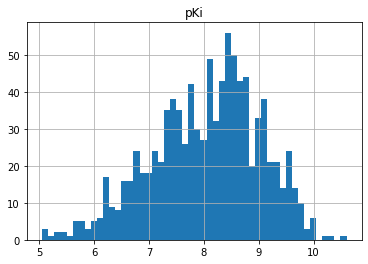

In [6]:
H3.hist('pKi', bins = 50)

#### Build a molecule record from smiles strings

In [7]:
#for index, row in H3.iterrows():
#    H3.loc[index, 'ROMol'] = Chem.MolFromSmiles(row['SMILES'])
PandasTools.AddMoleculeColumnToFrame(H3, smilesCol = "SMILES")

C:\Users\us16120\Anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:416: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


,TargetID,TargetName,SMILES,AnalogSeriesID,pKi,ROMol
1558,CHEMBL264,Histamine H3 receptor,C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,23663,7.96,

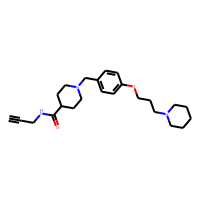

In [8]:
H3.head(1)

#### Calculate fingerprints

In [9]:
radius = 2
nBits = 1024

In [10]:
ECFP4 = [AllChem.GetMorganFingerprintAsBitVect(x, radius = radius, nBits = nBits) for x in H3['ROMol']]

In [11]:
ecfp4_names = [f'Bit_{i}' for i in range(nBits)]
ecfp4_bits = [list(l) for l in ECFP4]
H3_ecfp4 = pd.DataFrame(ecfp4_bits, index = H3.SMILES, columns = ecfp4_names)

In [12]:
H3_ecfp4.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
H3_pKi = H3[['SMILES', 'pKi']]
H3_pKi.set_index('SMILES', inplace = True)

In [14]:
H3_pKi.head(1)

,pKi
SMILES,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96


In [15]:
H3_Xy = H3_pKi.merge(H3_ecfp4, on = 'SMILES')

In [16]:
H3_Xy.head(1)

,pKi,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C#CCNC(=O)C1CCN(CC1)Cc2ccc(cc2)OCCCN3CCCCC3,7.96,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(H3.loc[1558, 'ROMol'], radius=2, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())[:10]

[2, 13, 80, 93, 102, 197, 257, 310, 322, 550]

In [18]:
from ipywidgets import interact, fixed, IntSlider
def renderFpBit(mol, bitIdx, bitInfo,fn):
    bid = bitIdx
    return(display(fn(mol, bid, bitInfo)))

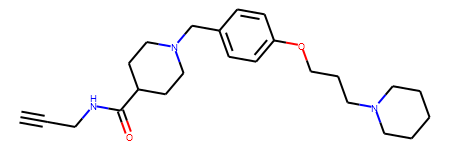

In [20]:
H3.loc[1558, 'ROMol']

In [19]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(H3.loc[1558, 'ROMol']),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(2, 13, 80, 93, 102, 197, 257, 310, 322, 550, 650…

#### Build training and test sets

In [58]:
X_train, X_test, y_train, y_test = train_test_split(H3_Xy.drop(['pKi'], axis = 1), H3_Xy['pKi'],
                                                   test_size = 0.2,
                                                   random_state = 42)

In [22]:
X_train.head(1)

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [30]:
pd.DataFrame(y_train).head(3)

,pKi
SMILES,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,6.97
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,7.46
COc1cccc(n1)c2cc3c(nc2)nc(o3)N4CCC(CC4)N5CCCCC5,7.64


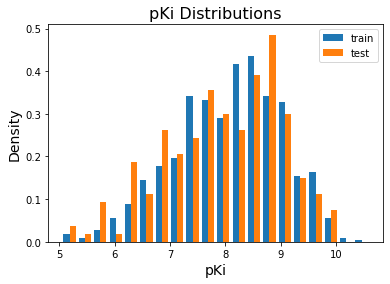

In [31]:
# create dataframe, select columns
df1x = pd.to_numeric(pd.DataFrame(y_train)['pKi'])
df2x = pd.to_numeric(pd.DataFrame(y_test)['pKi'])
#Stack the data
plt.figure()
plt.hist([df1x,df2x], bins = 20, stacked = False, density = True)
plt.title('pKi Distributions', fontsize = 16)
plt.xlabel('pKi', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(['train', 'test'])
plt.show()

#### Random Forest Regression

##### Load libraries

In [32]:
from sklearn.ensemble import RandomForestRegressor

##### Create random forest regressor

In [33]:
rf = RandomForestRegressor(random_state = 42, n_jobs = -1)

In [35]:
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [36]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


##### Train model

In [37]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose = 2, random_state = 42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 42.7min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [38]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': False}

In [40]:
best_random = rf_random.best_estimator_

In [59]:
best_random.score(X_train, y_train)

0.9967480039312516

In [60]:
best_random.score(X_test, y_test)

0.657239052550656

In [62]:
predict_train = pd.DataFrame(best_random.predict(X_train).flatten())
predict_train['set'] = 'train'
predict_test = pd.DataFrame(best_random.predict(X_test).flatten())
predict_test['set'] = 'test'

pred = predict_train.append(predict_test)
pred.columns = ['pred', 'set']

expt_train = pd.DataFrame(y_train)
expt_train['set'] = 'train'
expt_test = pd.DataFrame(y_test)
expt_test['set'] = 'test'

expt = expt_train.append(expt_test)
expt.columns = ['expt', 'set']

In [63]:
pred.reset_index(inplace = True, drop = True)
expt.reset_index(inplace = True, drop = True)

Text(0, 0.5, 'Experimental pKi')

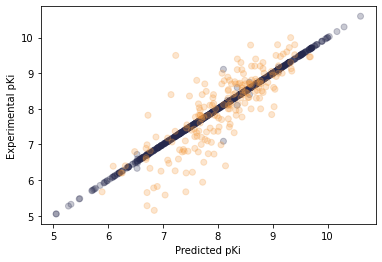

In [64]:
qaz = pd.concat([expt, pred['pred']], axis = 1)

qaz['color'] = np.where(qaz['set'] == 'train', '#26294d', '#f59b3f')

xPlot = qaz['pred']
yPlot = qaz['expt']
colors = qaz['color']

plt.scatter(xPlot, yPlot, c = colors, alpha = 0.25)
plt.xlabel("Predicted pKi")
plt.ylabel("Experimental pKi")

#### SHAP

In [65]:
import shap

In [66]:
# load JS visualization code to notebook
shap.initjs()

In [68]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(best_random)
shap_values = explainer.shap_values(X_train, check_additivity = False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


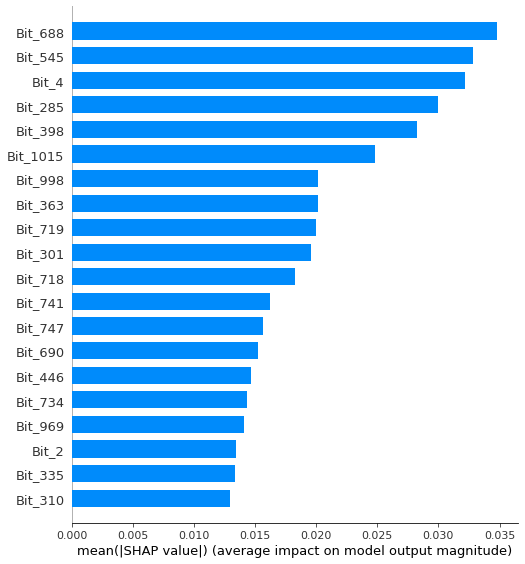

In [69]:
shap.summary_plot(shap_values, X_train, plot_type = 'bar')

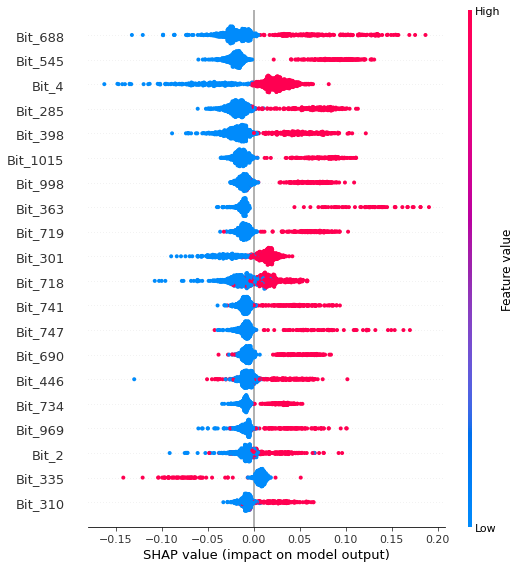

In [70]:
shap.summary_plot(shap_values, X_train)

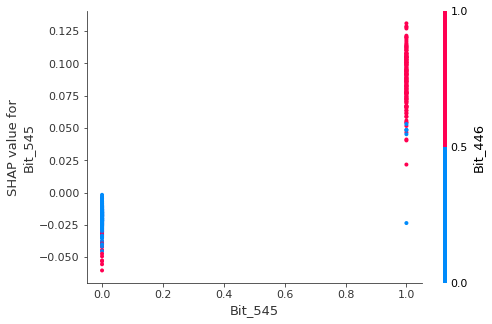

In [71]:
shap.dependence_plot("Bit_545", shap_values, X_train)

In [85]:
# Get the predictions and put them in with the test data
X_output = X_test.copy()
X_output.loc[:, 'predict'] = np.round(best_random.predict(X_output), 2)

# Randomly pick some observations
random_picks = np.arange(1, 200, 10)
qaz = X_output.iloc[random_picks]
qaz

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023,predict
SMILES,,,,,,,,,,,,,,,,,,,,,
CC1CCCN1CCc2ccc3c(c2)ccc(n3)c4cc(no4)C(=O)OC,0,1,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,8.82
CC(C)N1CCC(CC1)Oc2ccc(cc2)CNC3CC3,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,8.11
CC(C)N1CCCN(CC1)C(=O)c2ccc(c(c2)CNC)Oc3cccc(c3)Cl,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,8.84
CC(C)N1CCC(CC1)Oc2ccc3c(c2)ccc(n3)C(=O)N4CCC4,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6.87
CC(C)N1CCC(CC1)CCc2c[nH]cn2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,7.70
CC1CC(CN(C1)Cc2ccc(cc2)c3ccc(cc3)CN4CC(CC(C4)C)C)C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.14
CC1C2CCC3C2(CCC4C3CC=C5C4(CCC(C5)N(C)C(=O)c6ccncc6)C)CN1C,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,7.71
c1cc(cc2c1cc(cc2)OCCCN3CCCCC3)C(=O)N4CCC(CC4)CO,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,8.06
CCOc1ccccc1OCC2CN(CCO2)C3CCCC3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,6.71


In [78]:
def shap_plot(j):
    explainerModel = shap.TreeExplainer(best_random)
    shap_values_Model = explainerModel.shap_values(qaz)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], qaz.iloc[[j]])
    return(p)

In [79]:
y_train.mean()

8.064960937500013

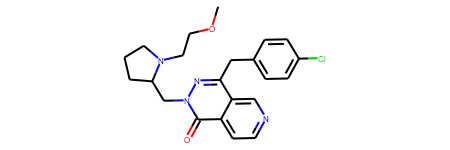

In [86]:
m = Chem.MolFromSmiles('COCCN1CCCC1Cn2c(=O)c3ccncc3c(n2)Cc4ccc(cc4)Cl')
m

In [87]:
shap_plot(18)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [88]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius = 2, nBits = 1024, bitInfo = bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[4,
 13,
 33,
 39,
 46,
 80,
 92,
 121,
 158,
 178,
 184,
 216,
 223,
 241,
 282,
 301,
 310,
 314,
 333,
 343,
 356,
 378,
 406,
 434,
 446,
 456,
 486,
 504,
 511,
 528,
 561,
 562,
 579,
 596,
 617,
 650,
 659,
 690,
 695,
 726,
 730,
 816,
 841,
 842,
 849,
 873,
 903,
 908,
 910,
 926,
 932,
 935,
 944,
 994,
 998,
 1005,
 1019,
 1020]

In [89]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(4, 13, 33, 39, 46, 80, 92, 121, 158, 178, 184, 2…

In [47]:
shap_plot(1)

In [48]:
shap_plot(2)

In [49]:
shap_plot(3)

In [50]:
m = Chem.MolFromSmiles('Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C')

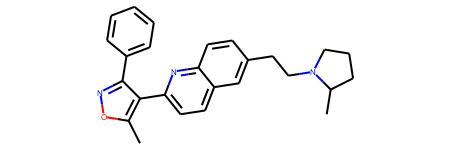

In [51]:
m

In [52]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, nBits = 1024, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[1,
 4,
 33,
 64,
 72,
 73,
 80,
 104,
 118,
 121,
 136,
 175,
 203,
 219,
 248,
 285,
 301,
 310,
 323,
 342,
 356,
 361,
 363,
 378,
 389,
 446,
 456,
 461,
 471,
 476,
 518,
 545,
 656,
 682,
 690,
 698,
 719,
 723,
 726,
 730,
 734,
 736,
 774,
 831,
 835,
 849,
 875,
 926,
 927,
 935,
 936,
 961,
 980,
 998,
 1015,
 1019]

In [53]:
bi

{1: ((13, 2),),
 4: ((26, 1),),
 33: ((0, 0), (29, 0)),
 64: ((8, 1), (9, 1), (10, 1)),
 72: ((15, 2),),
 73: ((20, 1),),
 80: ((22, 0), (23, 0)),
 104: ((17, 2),),
 118: ((21, 2),),
 121: ((23, 1),),
 136: ((6, 1),),
 175: ((8, 2), (10, 2)),
 203: ((14, 2),),
 219: ((22, 1),),
 248: ((5, 1),),
 285: ((29, 1),),
 301: ((27, 1),),
 310: ((18, 2),),
 323: ((3, 1),),
 342: ((1, 2),),
 356: ((1, 0), (2, 0), (3, 0), (6, 0), (12, 0), (15, 0), (17, 0), (20, 0)),
 361: ((4, 2),),
 363: ((16, 2),),
 378: ((4, 0), (21, 0)),
 389: ((9, 2),),
 446: ((26, 2),),
 456: ((25, 1),),
 461: ((5, 2),),
 471: ((6, 2),),
 476: ((3, 2),),
 518: ((4, 1),),
 545: ((27, 2),),
 656: ((5, 0),),
 682: ((2, 2),),
 690: ((25, 2),),
 698: ((0, 1),),
 719: ((28, 2),),
 723: ((2, 1),),
 726: ((7, 1), (13, 1), (14, 1), (18, 1), (19, 1), (11, 1)),
 730: ((17, 1),),
 734: ((28, 1),),
 736: ((7, 2), (11, 2)),
 774: ((22, 2),),
 831: ((21, 1), (15, 1)),
 835: ((1, 1),),
 849: ((7, 0),
  (8, 0),
  (9, 0),
  (10, 0),
  (11, 0

In [54]:
interact(renderFpBit, bitIdx=list(bi.keys()), mol = fixed(m),
         bitInfo = fixed(bi), fn = fixed(Draw.DrawMorganBit));

interactive(children=(Dropdown(description='bitIdx', options=(1, 4, 33, 64, 72, 73, 80, 104, 118, 121, 136, 17…

In [67]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations = 10, population_size = 50, verbosity = 2)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_H3_pipeline.py')

Generation 1 - Current best internal CV score: -0.3908982668400402
Generation 2 - Current best internal CV score: -0.3868540058310413
Generation 3 - Current best internal CV score: -0.3868540058310413
Generation 4 - Current best internal CV score: -0.37717937922751776
Generation 5 - Current best internal CV score: -0.37717937922751776
Generation 6 - Current best internal CV score: -0.37717937922751776
Generation 7 - Current best internal CV score: -0.37496804902516817
Generation 8 - Current best internal CV score: -0.35988523577187326
Generation 9 - Current best internal CV score: -0.35988523577187326
Generation 10 - Current best internal CV score: -0.35988523577187326

Best pipeline: RidgeCV(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False))
-0.31703448414886826


In [68]:
tpot

TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=5,
              disable_update_check=False, early_stop=None, generations=10,
              max_eval_time_mins=5, max_time_mins=None, memory=None,
              mutation_rate=0.9, n_jobs=1, offspring_size=None,
              periodic_checkpoint_folder=None, population_size=50,
              random_state=None, scoring=None, subsample=1.0, template=None,
              use_dask=False, verbosity=2, warm_start=False)

In [69]:
import numpy as np
import pandas as pd
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

In [70]:
# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = H3_Xy
features = tpot_data.drop('pKi', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['pKi'], random_state = None)

# Average CV score on the training set was: -0.35988523577187326
exported_pipeline = make_pipeline(
    PolynomialFeatures(degree = 2, include_bias = False, interaction_only = False),
    RidgeCV()
)

In [71]:
exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

In [72]:
exported_pipeline.score(training_features, training_target)

0.9929515829910854

In [73]:
exported_pipeline.score(testing_features, testing_target)

0.6448942245671135

In [76]:
len(results)

241

In [77]:
H3_Xy.shape

(961, 1025)

In [78]:
training_results = exported_pipeline.predict(training_features)
testing_results = exported_pipeline.predict(testing_features)

In [79]:
type(training_results)

numpy.ndarray

In [115]:
predict_train = pd.DataFrame(exported_pipeline.predict(training_features).flatten())
predict_train['set'] = 'train'
predict_test = pd.DataFrame(exported_pipeline.predict(testing_features).flatten())
predict_test['set'] = 'test'

pred = predict_train.append(predict_test)
pred.columns = ['pred', 'set']

In [81]:
pred.head()

,pred,set
0,9.063412,train
1,8.680474,train
2,7.128887,train
3,8.641712,train
4,7.110040,train


In [82]:
y.head()

,pKi,set,pred,color
SMILES,,,,
CCCN1CCC(CC1)Oc2ccc(cc2)C#N,6.97,train,7.0341,#26294d
c1cc2cccnc2c(c1)c3cc4c(nc3)nc(o4)N5CCC(CC5)N6CCCCC6,7.46,train,7.2653,#26294d
COc1cccc(n1)c2cc3c(nc2)nc(o3)N4CCC(CC4)N5CCCCC5,7.64,train,7.4834,#26294d
CC1CCCN1CCCOc2ccc(cc2)C(=O)CN3CCN(CC3)C(=O)c4ccc(cc4)F,9.22,train,8.9920,#26294d
CC(C)N1CCC(CC1)Oc2ccc3c(c2)ccc(n3)C(=O)N4CCOCC4,6.62,train,6.8320,#26294d


In [84]:
training_target.head()

SMILES
c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3                           9.04
c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl               8.70
CCCC=CCNC(=O)OCCCc1c[nH]cn1                                7.12
CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4ccc(cc4)Cl    8.60
COCCNCc1cc(no1)OCCCN2CCCCC2                                7.10
Name: pKi, dtype: float64

In [114]:
expt_train = pd.DataFrame(training_target)
expt_train['set'] = 'train'
expt_test = pd.DataFrame(testing_target)
expt_test['set'] = 'test'

expt = expt_train.append(expt_test)
expt.columns = ['expt', 'set']

In [87]:
expt.head()

,expt,set
SMILES,,
c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3,9.04,train
c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl,8.70,train
CCCC=CCNC(=O)OCCCc1c[nH]cn1,7.12,train
CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4ccc(cc4)Cl,8.60,train
COCCNCc1cc(no1)OCCCN2CCCCC2,7.10,train


In [93]:
type(pred['pred'])

#expt['pred'] = pred['pred']

#expt['color'] = np.where(expt['set'] == 'train', '#26294d', '#f59b3f')

pandas.core.series.Series

In [90]:
expt['expt']

SMILES
c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3                           9.04
c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl               8.70
CCCC=CCNC(=O)OCCCc1c[nH]cn1                                7.12
CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4ccc(cc4)Cl    8.60
COCCNCc1cc(no1)OCCCN2CCCCC2                                7.10
                                                           ... 
c1cc(ccc1C#N)OC2CCN(CC2)C3CCCCC3                           7.49
CC(C)N1CCN(CC1)C(=O)c2ccc(nc2)Oc3ccc(cc3)SC                6.64
CC1CCN(CC1)C(=O)c2ccc3cc(ccc3c2)OC4CCN(CC4)C(C)C           7.47
Cc1c(c(on1)c2ccc3cc(ccc3n2)CCN4CCCC4C)C(=O)OC              9.15
CC(=O)Nc1cc2c(cn1)nc(s2)N3CCC(CC3)N4CCCCC4                 7.28
Name: expt, Length: 961, dtype: float64

In [118]:
expt.reset_index(inplace = True)
pred.reset_index(inplace = True, drop = True)

In [119]:
expt.head()

,SMILES,expt,set
0,c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3,9.04,train
1,c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl,8.70,train
2,CCCC=CCNC(=O)OCCCc1c[nH]cn1,7.12,train
3,CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4c...,8.60,train
4,COCCNCc1cc(no1)OCCCN2CCCCC2,7.10,train


In [120]:
pred.head()

,pred,set
0,9.063412,train
1,8.680474,train
2,7.128887,train
3,8.641712,train
4,7.110040,train


In [121]:
qaz = pd.concat([expt, pred['pred']], axis = 1)

In [122]:
qaz.head()

,SMILES,expt,set,pred
0,c1cc(ccc1CN2CCCCC2)C#CCCN3CCCCC3,9.04,train,9.063412
1,c1cc(ccc1OC2CC(NC2)C(=O)N3CCCN(CC3)C4CCC4)Cl,8.70,train,8.680474
2,CCCC=CCNC(=O)OCCCc1c[nH]cn1,7.12,train,7.128887
3,CC(C)N1CCC(CC1)Oc2ccc(cc2)N3CCN(CC3=O)C(=O)c4c...,8.60,train,8.641712
4,COCCNCc1cc(no1)OCCCN2CCCCC2,7.10,train,7.110040


Text(0, 0.5, 'Experimental pKi')

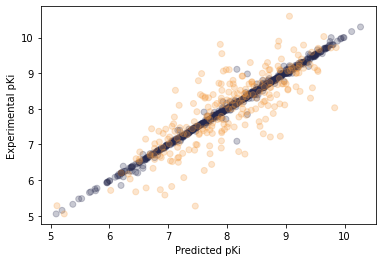

In [124]:
qaz['color'] = np.where(qaz['set'] == 'train', '#26294d', '#f59b3f')

xPlot = qaz['pred']
yPlot = qaz['expt']
colors = qaz['color']

plt.scatter(xPlot, yPlot, c = colors, alpha = 0.25)
plt.xlabel("Predicted pKi")
plt.ylabel("Experimental pKi")

In [138]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.KernelExplainer(exported_pipeline.predict, shap.sample(training_features, 1))
shap_values = explainer.shap_values(testing_features)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

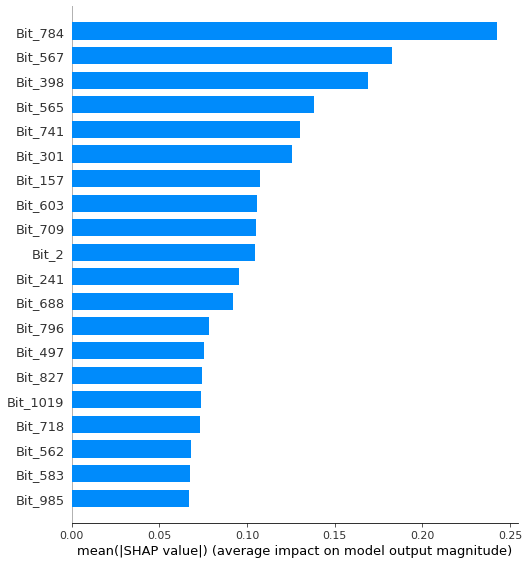

In [139]:
shap.summary_plot(shap_values, training_features, plot_type = 'bar')

In [142]:
shap_values.shape

(241, 1024)

In [143]:
training_features.shape

(720, 1024)

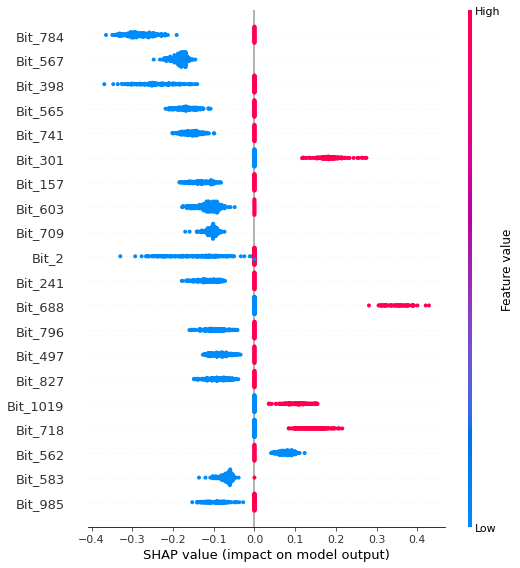

In [144]:
shap.summary_plot(shap_values, testing_features)

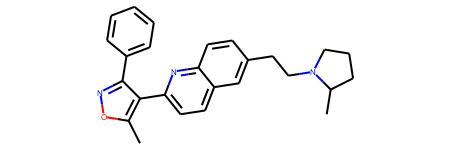

In [146]:
m = Chem.MolFromSmiles('Cc1c(c(no1)c2ccccc2)c3ccc4cc(ccc4n3)CCN5CCCC5C')
m

In [147]:
bi = {}
fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(m, radius=2, nBits = 1024, bitInfo=bi)
# show 10 of the set bits:
list(fp.GetOnBits())

[1,
 4,
 33,
 64,
 72,
 73,
 80,
 104,
 118,
 121,
 136,
 175,
 203,
 219,
 248,
 285,
 301,
 310,
 323,
 342,
 356,
 361,
 363,
 378,
 389,
 446,
 456,
 461,
 471,
 476,
 518,
 545,
 656,
 682,
 690,
 698,
 719,
 723,
 726,
 730,
 734,
 736,
 774,
 831,
 835,
 849,
 875,
 926,
 927,
 935,
 936,
 961,
 980,
 998,
 1015,
 1019]